# <img style="float: left; padding-right: 10px; width: 45px" src="style/iacs.png"> S-109A Introduction to Data Science: 

## Homework 5: Logistic Regression, High Dimensionality and PCA, LDA/QDA


<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [76]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

alpha = 0.5

## Cancer Classification from Gene Expressions

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5_1.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build a classification models for this data set. We will also use Principal Components Analysis (PCA) to visualize the data and to reduce its dimensions. 



## Question 1: Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

5. Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

#### Answers:
**1.1:** First step is to split the observations into an approximate 50-50 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits).

In [103]:
np.random.seed(9002)
df = pd.read_csv('data/dataset_hw5_1.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**1.2:** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


In [104]:
data_train.sample(5)

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
61,1,-112,-185,24,170,-197,-400,-215,-227,100,...,146,621,34,295,4,1110,174,8,533,-4
58,0,-12,-172,12,172,-137,-205,358,-104,-25,...,195,922,53,302,-78,673,208,-68,226,78
28,1,7,-100,-57,132,-377,-478,-351,-290,283,...,93,336,-45,170,12,752,295,28,1558,-67
65,1,-157,-370,-77,340,-438,-364,-216,-210,-86,...,318,408,-275,352,18,1372,642,-9,608,-71
69,1,-58,-217,63,95,-191,-230,-86,-152,-6,...,63,297,36,358,2,423,41,0,1777,-49


In [105]:
data_train.describe()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.37500,-116.125000,-163.350000,-9.125000,209.075000,-250.325000,-379.925000,-118.775000,-195.42500,82.850000,...,185.175000,641.250000,-14.800000,419.175000,-31.400000,818.875000,283.850000,11.425000,491.450000,-32.750000
std,0.49029,102.783364,95.437871,101.998539,111.000205,107.218776,123.026449,304.307494,100.91654,99.683743,...,87.141173,305.573085,92.745088,394.131039,54.429818,458.186178,197.123227,36.221461,653.148075,37.159221
min,0.00000,-476.000000,-531.000000,-168.000000,-24.000000,-496.000000,-696.000000,-1038.000000,-452.00000,-148.000000,...,42.000000,91.000000,-295.000000,-24.000000,-220.000000,67.000000,-42.000000,-100.000000,-33.000000,-108.000000
25%,0.00000,-140.750000,-208.500000,-81.250000,124.250000,-316.500000,-461.750000,-269.250000,-238.50000,-0.250000,...,133.750000,424.500000,-57.250000,241.750000,-57.250000,540.000000,189.000000,-8.250000,151.000000,-62.750000
50%,0.00000,-109.000000,-150.000000,-29.000000,228.000000,-225.000000,-384.500000,-77.000000,-172.00000,99.000000,...,179.500000,619.000000,10.500000,343.000000,-21.000000,747.000000,282.000000,10.000000,242.000000,-30.500000
75%,1.00000,-64.750000,-99.500000,47.000000,303.750000,-178.750000,-286.250000,20.500000,-125.75000,164.500000,...,227.000000,728.000000,52.250000,475.750000,11.250000,1042.500000,351.750000,28.250000,536.000000,-12.750000
max,1.00000,86.000000,-20.000000,262.000000,431.000000,-32.000000,-122.000000,367.000000,-11.00000,283.000000,...,413.000000,1655.000000,132.000000,2527.000000,50.000000,2313.000000,1108.000000,81.000000,3192.000000,78.000000


In [106]:
for column in list(data_train.columns)[1:]:
    series = data_train[column]
    a = series.min()
    b = series.max()
    data_train[column] = data_train[column].apply(lambda x: (x-a)/(b-a))
    
    # Apply the same transformation to test data
    data_test[column] = data_test[column].apply(lambda x: (x-a)/(b-a))
    
    # Do the same with the entire dataset (it will be used in question 1.5)
    series = df[column]
    a = series.min()
    b = series.max()
    df[column] = df[column].apply(lambda x: (x-a)/(b-a))

<ipython-input-106-cce88d357a77>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[column] = data_train[column].apply(lambda x: (x-a)/(b-a))
<ipython-input-106-cce88d357a77>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test[column] = data_test[column].apply(lambda x: (x-a)/(b-a))


In [107]:
data_train.describe()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.37500,0.640347,0.719472,0.369477,0.512253,0.529472,0.550653,0.654253,0.581803,0.535615,...,0.385916,0.351822,0.656206,0.173726,0.698519,0.334762,0.283348,0.615608,0.162620,0.404570
std,0.49029,0.182889,0.186767,0.237206,0.243956,0.231075,0.214332,0.216589,0.228836,0.231285,...,0.234882,0.195379,0.217202,0.154501,0.201592,0.204001,0.171412,0.200119,0.202527,0.199781
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.596530,0.631115,0.201744,0.325824,0.386853,0.408101,0.547153,0.484127,0.342807,...,0.247305,0.213235,0.556792,0.104175,0.602778,0.210597,0.200870,0.506906,0.057054,0.243280
50%,0.00000,0.653025,0.745597,0.323256,0.553846,0.584052,0.542683,0.683986,0.634921,0.573086,...,0.370620,0.337596,0.715457,0.143865,0.737037,0.302760,0.281739,0.607735,0.085271,0.416667
75%,1.00000,0.731762,0.844423,0.500000,0.720330,0.683728,0.713850,0.753381,0.739796,0.725058,...,0.498652,0.407289,0.813232,0.195904,0.856481,0.434328,0.342391,0.708564,0.176434,0.512097
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [108]:
data_test.describe()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,...,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.303030,0.641055,0.733737,0.371388,0.409524,0.512409,0.479516,0.744937,0.606473,0.533502,...,0.328188,0.387352,0.664112,0.141442,0.679686,0.297215,0.322661,0.597355,0.120583,0.429456
std,0.466694,0.165245,0.189658,0.335398,0.239065,0.298177,0.309424,0.174231,0.222876,0.187403,...,0.271523,0.194909,0.193956,0.138439,0.180964,0.194876,0.186667,0.296720,0.179463,0.233766
min,0.000000,0.112100,0.174168,-0.562791,-0.026374,-0.096983,-0.198606,0.489680,-0.024943,0.153132,...,-0.269542,0.021739,0.257611,0.014504,0.266667,0.029386,0.035652,-0.591160,-0.010853,-0.440860
25%,0.000000,0.560498,0.618395,0.255814,0.232967,0.312500,0.240418,0.620641,0.519274,0.406032,...,0.164420,0.268542,0.578454,0.076833,0.551852,0.203028,0.184348,0.508287,0.046202,0.349462
50%,0.000000,0.683274,0.767123,0.374419,0.373626,0.566810,0.496516,0.716726,0.625850,0.494200,...,0.239892,0.350384,0.662763,0.103489,0.677778,0.269368,0.322609,0.607735,0.074729,0.451613
75%,1.000000,0.749110,0.872798,0.504651,0.558242,0.698276,0.736934,0.839146,0.752834,0.635731,...,0.463612,0.475703,0.768150,0.163073,0.796296,0.330365,0.423478,0.751381,0.090853,0.575269
max,1.000000,0.873665,1.013699,1.116279,0.923077,1.314655,0.954704,1.243416,0.970522,0.928074,...,0.846361,0.872123,1.201405,0.769502,1.007407,0.838379,0.824348,1.187845,0.791628,0.795699


**1.3:** Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?


----

We can foresee that fitting a classification model will result in an overfit at the dataset. We can allso foresee multicollinearity among many features and problems inverting matrices.

----

**1.4:** Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

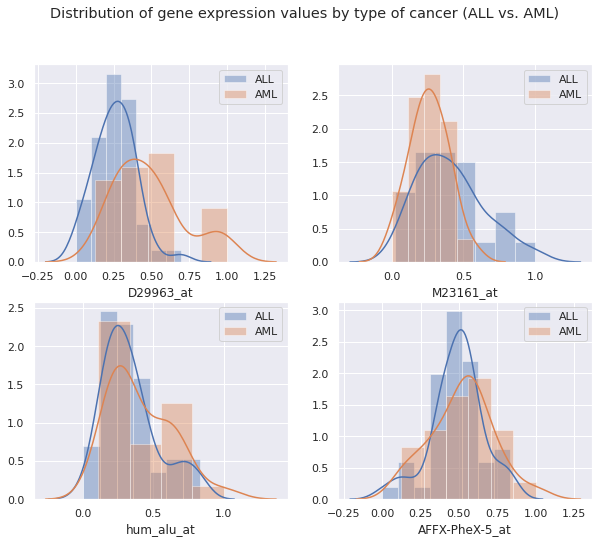

In [110]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
all_df = df[df.Cancer_type == 0]
aml_df = df[df.Cancer_type == 1]
for i, column in enumerate(['D29963_at', 'M23161_at', 'hum_alu_at', 'AFFX-PheX-5_at']):
    sns.distplot(all_df[column], ax = axes.reshape(4)[i], label='ALL')
    sns.distplot(aml_df[column], ax = axes.reshape(4)[i], label='AML')
    axes.reshape(4)[i].legend()
fig.suptitle('Distribution of gene expression values by type of cancer (ALL vs. AML)')
plt.show()

----

We see that the distributions of the gene expression are not the same for the two types of cancer and the four genes considerated. For example, _D29963_at_ has different means, modes and variances. _M23161_at_ also has a significant difference.

----

**1.5:** Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

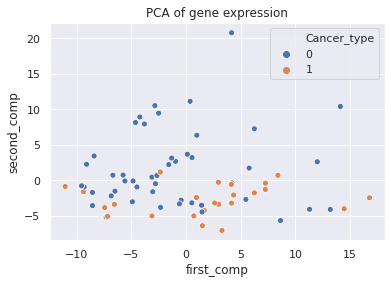

In [121]:
pca = PCA(n_components=2).fit(df.drop(columns='Cancer_type'))
pca_X = pca.transform(df.drop(columns='Cancer_type'))
pca_df = pd.DataFrame(pca_X, columns=['first_comp', 'second_comp'])

sns.scatterplot(x=pca_df.first_comp, y=pca_df.second_comp, hue=df.Cancer_type)
plt.title('PCA of gene expression')
plt.show()

In [123]:
pca.explained_variance_ratio_.sum()

0.25472890139389837

----

The PCA does a good job discriminating between the two classes of cancer, considering that we had many many features. The two first components explain around $25\%$ of the variance of the data.

----

## Question 2: Linear Regression vs. Logistic Regression

In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor, `D29963_at`, to explore these two methods.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

4. Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

#### Answers: 

**2.1:** Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?


In [133]:
X_train = data_train['D29963_at'].to_numpy()
y_train = data_train['Cancer_type'].to_numpy()
ols_model = OLS(y_train, sm.add_constant(X_train)).fit()

----

One problem with this intepretation is that we could have an estimation of probability greater than 1 or smaller than 0. Another ptoblem is that we are assuming that the data can be classified with a linear regression (it's the assumption, it could not be true).

----

**2.2:** The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.


In [190]:
missclassification = (ols_model.predict(sm.add_constant(X_train)) > 0.5) != y_train
print('Classification accuracy on the training set: {}'.format(1 - missclassification.sum()/len(X_train)))

Classification accuracy on the training set: 0.8


In [192]:
X_test = data_test['D29963_at'].to_numpy()
y_test = data_test['Cancer_type'].to_numpy()
missclassification = (ols_model.predict(sm.add_constant(X_test)) > 0.5) != y_test
print('Classification accuracy on the test set: {:.4f}'.format(1 - missclassification.sum()/len(X_test)))

Classification accuracy on the test set: 0.7576


**2.3:** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

In [193]:
lr_model = LogisticRegression(C=100000).fit(X_train.reshape(-1, 1), y_train)

In [209]:
missclassification = lr_model.predict(X_train.reshape(-1, 1)) != y_train
print('Classification accuracy on the training set: {}'.format(1 - missclassification.sum()/len(X_train)))

Classification accuracy on the training set: 0.8


In [210]:
missclassification = lr_model.predict(X_test.reshape(-1, 1)) != y_test
print('Classification accuracy on the test set: {:.4f}'.format(1 - missclassification.sum()/len(X_test)))

Classification accuracy on the test set: 0.7576


----

Both models perform the same on the training and test data!

----

**2.4:** Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

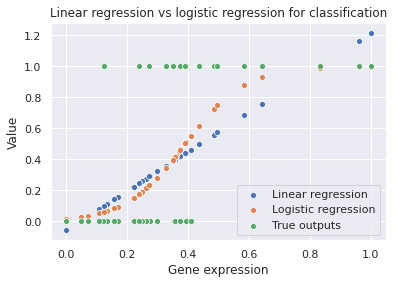

In [211]:
ax = sns.scatterplot(
    X_train,
    ols_model.predict(sm.add_constant(X_train)),
    label='Linear regression'
)
sns.scatterplot(
    X_train,
    lr_model.predict_proba(X_train.reshape(-1, 1))[:, 1],
    ax=ax,
    label='Logistic regression'
)
sns.scatterplot(X_train, y_train, ax=ax, label='True outputs')
plt.title('Linear regression vs logistic regression for classification')
plt.xlabel('Gene expression')
plt.ylabel('Value')
plt.show()

----

Logistic regression intuitively seems to be more appropriated to this problem. We also have that problem with linear regression already mentioned: if linear regression estimations are being interpreted as probabilites, we have probabilities greater than 1 and smaller than 0, which doesn't make sense.

----

## Question 3: Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

2. Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

In [212]:
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Cancer Type 0')

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

#### Answers 
**3.1:** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

In [218]:
X_train = data_train.iloc[:, 1:].to_numpy()
y_train = data_train['Cancer_type'].to_numpy()
X_test = data_test.iloc[:, 1:].to_numpy()
y_test = data_test['Cancer_type'].to_numpy()

In [245]:
mlr_model = LogisticRegression(C=100000).fit(X_train, y_train)

In [247]:
missclassification = mlr_model.predict(X_train) != y_train
print('Classification accuracy on the training set: {}'.format(1 - missclassification.sum()/len(X_train)))

Classification accuracy on the training set: 1.0


In [248]:
missclassification = mlr_model.predict(X_test) != y_test
print('Classification accuracy on the test set: {:.4f}'.format(1 - missclassification.sum()/len(X_test)))

Classification accuracy on the test set: 1.0000


----

This model has accuracy of 1 for both training and test dataset.

----

**3.2:** Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

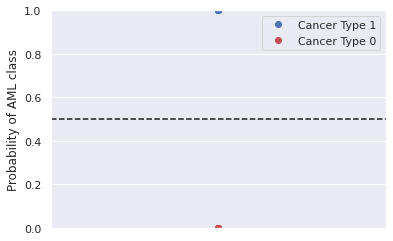

In [276]:
fig, ax = plt.subplots()
visualize_prob(mlr_model, X_train, y_train, ax)
plt.show()

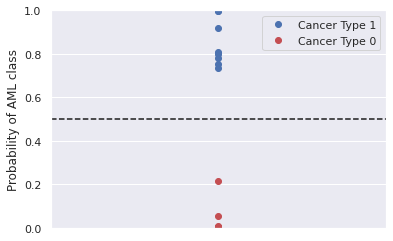

In [275]:
fig, ax = plt.subplots()
visualize_prob(mlr_model, X_test, y_test, ax)
plt.show()

----

The points for the training dataset are concentrated in the extremes, maybe because of overfitting. It would explain part of the fact that they are not so concentrated in the plot for the test dataset. We do not have points close to probability 0.5.

----

## Question 4: Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 1000 boostrap samples/iterations.  

#### Answer:

In [309]:
# From Homework 4, Question 1

# dataset_x should be a pandas dataframe

## accepts dataset inputs as numpy arrays
def make_bootstrap_sample(dataset_X, dataset_y, size = None):    
    dataset_X = dataset_X.copy()
    dataset_y = dataset_y.copy()
    
    # by default return a bootstrap sample of the same size as the original dataset
    if not size: size = len(dataset_X)
    
    # if the X and y datasets aren't the same size, raise an exception
    if len(dataset_X) != len(dataset_y):
        raise Exception("Data size must match between dataset_X and dataset_y")
    
    samples_indices = np.random.randint(0, len(dataset_X), len(dataset_X))
    
    bootstrap_dataset_X = dataset_X.iloc[samples_indices]
    bootstrap_dataset_y = dataset_y[samples_indices, :]
    
    # return as a tuple your bootstrap samples of dataset_X as a pandas dataframe
    # and your bootstrap samples of dataset y as a numpy column vector
    
    return (bootstrap_dataset_X, bootstrap_dataset_y)
    

def calculate_coefficients(dataset_X, dataset_y, model):
    
    features = list(dataset_X.columns)
    coef_ = list(model.coef_[0])    
    coefficients_dictionary = dict(zip(features, coef_))
    
    # return coefficients  in the variable  coefficients_dictionary as a dictionary
    # with the key being the name of the feature as a string
    # the value being the value of the coefficients
    # do not return the intercept as part of this
    return coefficients_dictionary


def get_significant_predictors(regression_coefficients, significance_level):
    features = list(regression_coefficients[0].keys())
    significant_coefficients = []
    for feature in features:
        values = [coefficients[feature] for coefficients in regression_coefficients]
        if np.quantile(values, significance_level/2) > 0:
            significant_coefficients.append(feature)
        else:
            if np.quantile(values, 1 - significance_level/2) < 0:
                significant_coefficients.append(feature)
    
    # regression_coefficients is a list of dictionaries
    # with the key being the name of the feature as a string
    # the value being the value of the coefficients
    # each dictionary in the list should be the output of calculate_coefficients
    
    # return the significant coefficients as a list of strings
    return significant_coefficients

In [310]:
X_train = data_train.drop(columns='Cancer_type')

In [311]:
y_train = data_train.Cancer_type.to_numpy()[..., np.newaxis]

In [312]:
regression_coefficients = []
for i in range(1000):
    bootstrap_sample = make_bootstrap_sample(X_train, y_train)
    model = LogisticRegression(C=100000).fit(bootstrap_sample[0], bootstrap_sample[1].reshape(-1))
    coefficients = calculate_coefficients(bootstrap_sample[0], bootstrap_sample[1], model)    
    regression_coefficients.append(coefficients)
significant_bootstrap = get_significant_predictors(regression_coefficients, 0.05)

In [319]:
print(
    ('{:.2f}% of the predictors are significantly ' +
    'different from zero at a significance level of 95%.').format(
        len(significant_bootstrap)/len(X_train.columns) * 100)
)

26.23% of the predictors are significantly different from zero at a significance level of 95%.


## Question 5: High Dimensionality

One of the issues you may run into when dealing with high dimensional data is that your 2D and 3D intuition may fail breakdown. For example, distance metrics in high dimensions can have properties that may feel counterintuitive.

Consider the following: You have a hypersphere with a radius of $1$, inside of a hypercube centered at $0$, with edges of length $2$.

1. As a function of $d$, the number of dimensions, how much of the hypercube's volume is contained within the hypersphere?
2. What happens as $d$ gets very large?
3. Using the functions provided below, create a plot of how the volume ratio changes as a function of $d$.
4. What does this tell you about where the majority of the volume of the hypercube resides in higher dimensions? 

*HINTS:* 
- The volume of a hypercube with edges of length $2$ is $V_c(d) = 2^d$.
- The volume of a hyperphere with a radius of $1$ is $V_s(d) = \frac{\pi^{\frac{d}{2}}} {\Gamma\left(\frac{d}{2}+1\right)}$, where $\Gamma$ is Euler's Gamma Function.
- $\Gamma$ is increasing for all $d \geq 1$.

In [321]:
def V_c(d):
    """
    Calculate the volumn of a hypercube of dimension d.
    """
    return 2**d

def V_s(d):
    """
    Calculate the volume of a hypersphere of dimension d.
    """
    return math.pi**(d/2)/gamma((d/2)+1)  

#### Answers:

In [324]:
x = list(range(1, 40))
y = [V_s(d)/V_c(d) for d in x]

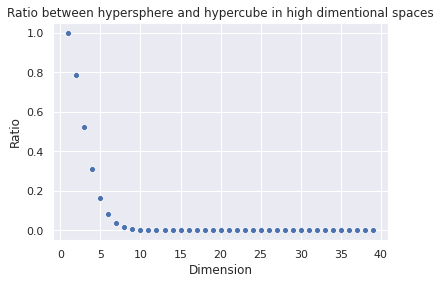

In [326]:
sns.scatterplot(x, y)
plt.title('Ratio between hypersphere and hypercube in high dimentional spaces')
plt.xlabel('Dimension')
plt.ylabel('Ratio')
plt.show()

----

1. As a function of $d$ (the number of dimensions), $\dfrac{V_s(d)}{V_c(d)} = \frac{\pi^{\frac{d}{2}}} {\Gamma\left(\frac{d}{2}+1\right) 2^d}$ of the hypercube is contained within the hypersphere.
2. Algebric manipulation:

$$\dfrac{V_s(d)}{V_c(d)} = \frac{\pi^{\frac{d}{2}}} {\Gamma\left(\frac{d}{2}+1\right) 2^d} = 
\dfrac{1}{\Gamma\left(\frac{d}{2}+1\right)} \left(\dfrac{\sqrt{\pi}}{2}\right)^d$$

When $d$ goes to infinity, the gamma function goes too, so its fraction goes to zero. The other factor also goes to zero, because the fraction is less than 1. So the original fraction also goes to zero.

4. The plot provides evidence of this.

----

## Question 6: PCA and Dimensionality Reduction

As we saw above, high dimensional problems can have counterintuitive behavior, thus we often want to try to reduce the dimensionality of our problems. A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the smallest set of principal components that explain at least 90% of the variance in the predictors.

1. Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

2. Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

#### Answers:

**6.1:** Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

In [427]:
pca = PCA().fit(data_train.drop(columns='Cancer_type'))

summation = 0
number = 0
for i, variance in enumerate(pca.explained_variance_ratio_):
    summation += variance
    if summation >= 0.9:
        number = i + 1
        break
print(('We need the first {} components in order ' +
       'to explain {:.4f}% of the variance of the data.').format(
    number,
    100*sum(pca.explained_variance_ratio_[:number])
))

We need the first 29 components in order to explain 90.2687% of the variance of the data.


In [428]:
X_train = pca.transform(data_train.drop(columns='Cancer_type'))[:, :number]
y_train = data_train.Cancer_type.to_numpy()
X_test = pca.transform(data_test.drop(columns='Cancer_type'))[:, :number]
y_test = data_test.Cancer_type.to_numpy()

mlr_pca_model = LogisticRegression(C=10000, max_iter=1000).fit(X_train, y_train)

missclassification = mlr_pca_model.predict(X_train) != y_train
print('Classification accuracy on the training set: {}'.format(1 - missclassification.sum()/len(X_train)))

missclassification = mlr_pca_model.predict(X_test) != y_test
print('Classification accuracy on the test set: {:.4f}'.format(1 - missclassification.sum()/len(X_test)))

Classification accuracy on the training set: 1.0
Classification accuracy on the test set: 0.9697


----

We need the first 29 components to explain 90% of the variance of the training data. The classification accuracy decreases for test data, but it's still good, compared to the those in Question 3.1.

----

**6.2:** Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the <s>lower</s> **higher** dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

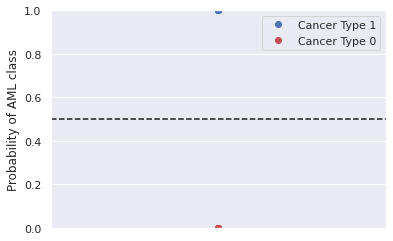

In [430]:
fig, ax = plt.subplots()
visualize_prob(mlr_pca_model, X_train, y_train, ax)
plt.show()

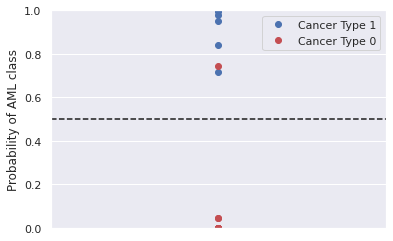

In [431]:
fig, ax = plt.subplots()
visualize_prob(mlr_pca_model, X_test, y_test, ax)
plt.show()

----

The difference between these graphs and those from question 3.2 is relative to test data: the last plot is more spread than the first one. Well, it's expected, because the accuracy is less than before.

The lower dimensional representation provides less overfitting, collinearity reduction, computational time improvements and visualizations (for 2, 3, 4 dimensions).

----


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw5_2.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI Machine Learning Repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the code provided below.

## Question 7: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
 <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

#### Answers:

**7.0:** First task: split the data using the code provided below. 

In [27]:
np.random.seed(9001)
df = pd.read_csv('data/dataset_hw5_2.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**7.1:** Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?


In [1]:
# your code here

----
Your answer here

----

**7.2:** Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).


----
Your answer here

----

**7.3:** Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

In [ ]:
# your code here

----
Your answer here

----

**7.4:** Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors

*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 


In [ ]:
# your code here

**7.5:** Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 

----
Your answer here

----

## Question 8: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [32]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree,include_bias = False)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
        
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.
3. QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

#### Answers:

**8.1:** Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.

In [ ]:
# your code here

**8.2:** Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

---
Your answer here

---

**8.3:** QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

---
Your answer here

---